Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [23]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
    dataset = dataset.reshape(
        (-1, image_size, image_size, num_channels)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [4]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [5]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal(
        [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal(
        [num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
    # Model.
    def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases
  
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [6]:
num_steps = 1001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
            valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.222317
Minibatch accuracy: 12.5%
Validation accuracy: 9.9%
Minibatch loss at step 50: 1.277407
Minibatch accuracy: 68.8%
Validation accuracy: 43.7%
Minibatch loss at step 100: 1.592893
Minibatch accuracy: 43.8%
Validation accuracy: 67.5%
Minibatch loss at step 150: 0.790199
Minibatch accuracy: 81.2%
Validation accuracy: 76.4%
Minibatch loss at step 200: 0.878689
Minibatch accuracy: 75.0%
Validation accuracy: 78.2%
Minibatch loss at step 250: 0.221369
Minibatch accuracy: 93.8%
Validation accuracy: 78.7%
Minibatch loss at step 300: 1.562321
Minibatch accuracy: 50.0%
Validation accuracy: 79.7%
Minibatch loss at step 350: 0.942235
Minibatch accuracy: 75.0%
Validation accuracy: 77.5%
Minibatch loss at step 400: 1.078443
Minibatch accuracy: 68.8%
Validation accuracy: 79.3%
Minibatch loss at step 450: 0.176861
Minibatch accuracy: 93.8%
Validation accuracy: 79.8%
Minibatch loss at step 500: 0.630532
Minibatch accuracy: 81.2%
Validation accuracy: 81.2%
Mi

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [8]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph_1 = tf.Graph()

with graph_1.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal(
        [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal(
        [num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
    # Model.
    def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        maxpoll = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        
        conv = tf.nn.conv2d(maxpoll, layer2_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        maxpoll = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        
        shape = maxpoll.get_shape().as_list()
        reshape = tf.reshape(maxpoll, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases
  
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [11]:
num_steps = 1001

with tf.Session(graph=graph_1) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 200 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
            valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.584539
Minibatch accuracy: 12.5%
Validation accuracy: 9.8%
Minibatch loss at step 200: 0.628608
Minibatch accuracy: 81.2%
Validation accuracy: 76.2%
Minibatch loss at step 400: 1.046089
Minibatch accuracy: 75.0%
Validation accuracy: 80.3%
Minibatch loss at step 600: 0.451162
Minibatch accuracy: 87.5%
Validation accuracy: 82.2%
Minibatch loss at step 800: 0.837434
Minibatch accuracy: 75.0%
Validation accuracy: 83.5%
Minibatch loss at step 1000: 0.746341
Minibatch accuracy: 75.0%
Validation accuracy: 83.5%
Test accuracy: 90.0%


---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

Implementation specification:

input size: 28 x 28 x 1

Layer 1
* convolution of a 5x5 filter on input => generating 28 x 28 x 16
* max pooling of 2x2 on layer 1 => generating 14 x 14 x 16

Layer 2
* convolution of a 5x5 filter on layer 2 => generating 14 x 14 x 16
* max pooling of 2x2 on layer 3 => generating 7 x 7 x 16

Layer 3
* connect 7 x 7 x 16 param to 64 parameter

Layer 4
* connect 64 parameter to 10 label set

dropout occur at layer 3 and layer 4

In [36]:
#kernel
batch_size = 512
patch_size = 5
depth = 16
num_hidden = 64
train_set_check_size = 50000

graph_2 = tf.Graph()

with graph_2.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_full_train_dataset = tf.placeholder(tf.float32, shape=(train_set_check_size, image_size, image_size, num_channels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_lambda = tf.placeholder(tf.float32)
    tf_dropout = tf.placeholder(tf.float32)
  
    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal(
        [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal(
        [num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
    # Model.
    def model(data, is_train):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        maxpoll = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        
        conv = tf.nn.conv2d(maxpoll, layer2_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        maxpoll = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        
        shape = maxpoll.get_shape().as_list()
        reshape = tf.reshape(maxpoll, [shape[0], shape[1] * shape[2] * shape[3]])
        
        
        if is_train:
            hidden = tf.nn.relu(tf.matmul(tf.nn.dropout(reshape, tf_dropout), layer3_weights) + layer3_biases)
            return tf.matmul(tf.nn.dropout(hidden, tf_dropout), layer4_weights) + layer4_biases
        else:
            hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
            return tf.matmul(hidden, layer4_weights) + layer4_biases
  
    # Training computation.
    logits = model(tf_train_dataset, True)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
    # Optimizer.
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(0.05, global_step, 1000, 0.9) #reduce every going through 40 x size(training_set)
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    mini_train_prediction = tf.nn.softmax(logits)
    train_prediction = tf.nn.softmax(model(tf_full_train_dataset, False))
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset, False))
    test_prediction = tf.nn.softmax(model(tf_test_dataset, False))

Initialized with dropout: 0.500000
Test accuracy: 89.9%
Initialized with dropout: 0.600000
Test accuracy: 90.8%
Initialized with dropout: 0.800000
Test accuracy: 92.1%
Initialized with dropout: 0.900000
Test accuracy: 92.3%
Initialized with dropout: 0.950000
Test accuracy: 92.1%
Initialized with dropout: 0.970000
Test accuracy: 92.2%
Initialized with dropout: 0.990000
Test accuracy: 92.5%


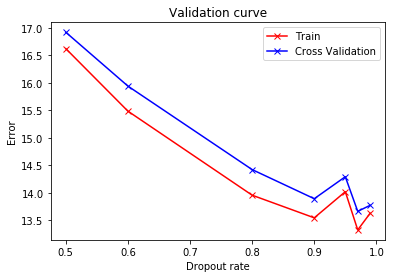

In [37]:
#dropout (no going to use dropout with l2 regularization)
dropouts = [0.5, 0.6, 0.8, 0.9, 0.95, 0.97, 0.99]
num_steps = 1001

error_trains = np.zeros(len(dropouts))
error_vals = np.zeros(len(dropouts))

for i, dropout in enumerate(dropouts) :
    with tf.Session(graph=graph_2) as session:
        tf.global_variables_initializer().run()
        print('Initialized with dropout: %f' % dropout)
        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_dropout : dropout}
            _, l, predictions = session.run(
              [optimizer, loss, mini_train_prediction], feed_dict=feed_dict)
            #if (step % 200 == 0):
            #    print('Minibatch loss at step %d: %f' % (step, l))
            #    print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            #    print('Validation accuracy: %.1f%%' % accuracy(
            #    valid_prediction.eval(), valid_labels))
        print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
        error_trains[i] = 100-accuracy(train_prediction.eval({tf_full_train_dataset: train_dataset[0:train_set_check_size,:]}), train_labels[0:train_set_check_size,:])
        error_vals[i] = 100-accuracy(valid_prediction.eval(), valid_labels)
        
plt.figure()
plt.plot(dropouts, error_trains, 'rx-', label='Train', )
plt.plot(dropouts, error_vals, 'bx-', label='Cross Validation')
plt.legend()
plt.title('Validation curve') 
plt.xlabel('Dropout rate')
plt.ylabel('Error')

In [38]:
#real model training

dropout = 0.97
num_steps = 10001

with tf.Session(graph=graph_2) as session:
    tf.global_variables_initializer().run()
    print('Initialized with dropout: %f' % dropout)
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_dropout : dropout}
        _, l, predictions = session.run(
          [optimizer, loss, mini_train_prediction], feed_dict=feed_dict)
        if (step % 1000 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
            valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized with dropout: 0.970000
Minibatch loss at step 0: 2.701284
Minibatch accuracy: 10.2%
Validation accuracy: 9.6%
Minibatch loss at step 1000: 0.459135
Minibatch accuracy: 86.9%
Validation accuracy: 86.0%
Minibatch loss at step 2000: 0.463510
Minibatch accuracy: 87.7%
Validation accuracy: 87.6%
Minibatch loss at step 3000: 0.386429
Minibatch accuracy: 88.5%
Validation accuracy: 88.3%
Minibatch loss at step 4000: 0.363259
Minibatch accuracy: 90.0%
Validation accuracy: 88.9%
Minibatch loss at step 5000: 0.374199
Minibatch accuracy: 88.7%
Validation accuracy: 89.0%
Minibatch loss at step 6000: 0.331812
Minibatch accuracy: 90.2%
Validation accuracy: 89.5%
Minibatch loss at step 7000: 0.308469
Minibatch accuracy: 91.2%
Validation accuracy: 89.6%
Minibatch loss at step 8000: 0.352278
Minibatch accuracy: 89.3%
Validation accuracy: 89.5%
Minibatch loss at step 9000: 0.353700
Minibatch accuracy: 89.8%
Validation accuracy: 89.8%
Minibatch loss at step 10000: 0.250726
Minibatch accuracy: 